In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [73]:
import glob
import warnings
import numpy as np
import pylab as plt

from scipy.optimize import least_squares
from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from parabolas import loadLeicaData, fitParabola, parabola
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot
from utils.utils import midPoint, radialMask
from zernikies import zernikeWLS, getZernikeCoeffs
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [88]:
def parabolaFit(x, y, z, guess, bounds=None, 
                max_nfev=10000, ftol=1e-12, 
                xtol=1e-12, f_scale=0.08, verbose=False):
    
    # Set boundaries for the fit parameters.
    if bounds is None:
        inf = np.inf
        pi2 = 2*np.pi
        b1 = [60-9e-2, -5, -5, -55, -pi2, -pi2, -1e-3, -1e-3, -1e-3, -2, 48]
        b2 = [60+9e-2,  5,  5, -45,  pi2,  pi2,  1e-3,  1e-3,  1e-3,  2, 52]
        bounds = (b1, b2)
    
    # Robust fit: weights outliers outside of f_scale less
    loss = "soft_l1"
    f_scale = f_scale

    method = fitParabola
    args = (x.flatten(), y.flatten(), z.flatten())
    
    r = least_squares(method,
                      guess,
                      args=args,
                      bounds=bounds,
                      max_nfev=max_nfev,
                      loss=loss,
                      f_scale=f_scale,
                      ftol=ftol,
                      xtol=xtol)
    return r

def removeParabolaFit(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xgdr, ygdr, zgdr = shiftRotateXYZ(x, y, z, cor)
    zp = parabola(xgdr, ygdr, fit[0], 0, 0, 0, 0, 0)
    diff = zgdr - zp
    return xgdr, ygdr, zgdr, diff

def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0, 0, 0], bounds=None, iters=2, f_scale=0.08):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        x_ = x[~mask]
        y_ = y[~mask]
        z_ = z[~mask]
        fit = parabolaFit(x_, y_, z_, guess, bounds=bounds, f_scale=f_scale)
        cor = np.hstack((-1*fit.x[1:4],fit.x[4:],0))
        xdr, ydr, zdr = shiftRotateXYZ(x, y, z, cor)
        zp = parabola(xdr, ydr, fit.x[0], 0, 0, 0, 0, 0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = res.mask
        guess = fit.x
        
    return fit, mask

def removeParabolaScan(filename, iters, n=512, guess=[60., 0, 0, -50., 0, 0], bounds=None, fit=None, f_scale=0.08):
    """
    """
    
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(178)])
    
    if fit is None:
        fit, mask = parabolaFitIterations(xg, yg, zg, guess=guess, bounds=bounds, iters=iters, f_scale=f_scale)
    else:
        mask = False
        
    cor = np.hstack((-1*fit.x[1:4],fit.x[4:6],0))
    xgdr, ygdr, zgdr = shiftRotateXYZ(xg, yg, zg, cor)
    #zgdr[mask] = np.nan
    #tht = np.arctan2(np.nanmax(zgdr)-np.nanmin(zgdr), np.nanmax(ygdr)-np.nanmin(ygdr))
    #xgr, ygr, zgr = shiftRotateXYZ(xgdr, ygdr, zgdr, [0, 0, 0, -tht, 0, 0])
    zp = parabola(xgdr, ygdr, fit.x[0], 0, 0, 0, 0, 0)
    #_, _, zpr = shiftRotateXYZ(xgdr, ygdr, zp, [0, 0, 0, -tht, 0, 0])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        #diff = sigma_clip(zgdr - zp)
        diff = zgdr - zp
    return xgdr, ygdr, zgdr, diff, fit

In [89]:
n = 512
iters = 1
nZern = 36
guess = [60., 2.5, -0.7, -49., 0.2, 0., 0, 0, 0, -0.9, 51.2]
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [90]:
%%time
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
#refScan = "{0}/ref_average.ptx.csv".format(scanDir)
xr, yr, zr, rDiff, rFit = removeParabolaScan(refScan, iters, n=n, guess=guess)

CPU times: user 3min 14s, sys: 2min 59s, total: 6min 13s
Wall time: 23.9 s


In [91]:
%%time

# Use the .zernike.fits files to select signal scans.
fitsDir = '/home/gbtdata/TLASSI_200315'
zern_files = natsorted(glob.glob("{0}/LASSI/*.zernike.fits".format(fitsDir)))[3:]

zFitDict = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i,ff in enumerate(zern_files):
        
        time = Time( '{0}T{1}'.format('-'.join(ff.split('/')[-1].split('.')[0].split("_")[:3]), 
                                  ff.split('/')[-1].split('.')[0].split("_")[-1]) )
        mjd = time.mjd

        sf = ff.replace(".zernike.fits", ".fits")
        sigScanFile = "{0}/{1}".format(scanDir, sf.split('/')[-1].replace('.fits', '.ptx.csv'))

        # Find the scan number.
        hdu = fits.open(sf)
        head = hdu[0].header
        scan = head['SCAN']

        xs, ys, zs, sDiff, sFit = removeParabolaScan(sigScanFile, iters, n=n, guess=guess)#, fit=rFit)
        
        diff = sigma_clip(sDiff - rDiff, 5)
        mask = binary_dilation(diff.mask, iterations=1)
        diff = np.ma.masked_where(mask, diff)
        xDiff = xr
        yDiff = yr

        fl = np.zeros(nZern+1, dtype=np.float)
        
        fl_fs = getZernikeCoeffs(diff.filled(0)[::-1].T, nZern, norm='active-surface')
        
        fl = fl_fs
        
        """
        flArr = np.zeros((len(stds), nZern+1), dtype=np.float)

        for j,std in enumerate(stds):
            if std != 0:
                kernel = Gaussian2DKernel(x_stddev=std)
                diffSmo = convolve(diff, kernel, preserve_nan=True)
            else:
                diffSmo = np.ma.copy(diff)
            diff_ = np.ma.copy(diffSmo)
            diff_[~radialMask(xDiff, yDiff, 49.5)] = np.nan
            diff_ = np.ma.masked_invalid(diff_)

            flArr[j] = zernikeWLS(xDiff[:,::-1], yDiff[::-1,:], diff_[::-1,::-1], nZern, weighted=False)
        
        
        for j in range(4,nZern+1):
            if j == 4:
                fl[j] = fl_Z4[j]
            else:
                if abs(fl_fs[j]) < abs(flArr[0,j]):# and j == 13:
                    fl[j] = fl_fs[j]
                if abs(fl_Z4[j]) > abs(fl_fs[j]):# and j == 13:
                    fl[j] = fl_Z4[j]
                else:
                    sb = scale_bias(betaDict[j])
                    #sb = scale_bias(diff.std()*1e6/400.)
                    best_idx = np.argmax(abs(flArr[1:,j])*1e6*sb[1:])
                    fl[j] = flArr[best_idx+1,j]
        """
        
        zFitDict[scan] = {'recovered zernike': fl,
                          #'recovered zernike fs': fl_fs,
                          #'recovered zernike wls': fl_wls,
                          #'parabola fir coefficients': fitS.x,
                          'deformation map z': diff,
                          'deformation map x': xDiff,
                          'deformation map y': yDiff,
                          'mjd': mjd
                         }

CPU times: user 52min 15s, sys: 48min 54s, total: 1h 41min 9s
Wall time: 6min 8s


In [62]:
%%time

asDict = {}

# Use the .zernike.fits files to select signal scans.
zern_files = natsorted(glob.glob("{0}/LASSI/*.zernike.fits".format(fitsDir)))[3:]

# Load the ScanLog
hdu = fits.open("{0}/ScanLog.fits".format(fitsDir))
scanArr = hdu[1].data

for i, zf in enumerate(zern_files):
    
    hdu = fits.open(zf)
    head = hdu[0].header
    scan = head['MC_SCAN']

    idx = np.where(scanArr['SCAN'] == scan)[0][0]
    idx_as = idx - 3
    sig_scan = scanArr['SCAN'][idx_as]
    ref_scan = scanArr['SCAN'][idx_as-6]

    # Load the AS fits file for the signal scan.
    as_file = file = '/'.join(scanArr[idx_as]['FILEPATH'].split('/')[-2:])
    hdu = fits.open("{0}/{1}".format(fitsDir, as_file))
    z_as = hdu[1].data['value']

    # The AS Zernike contents start at Z1, not Z0.
    # The LASSI Zernike start at Z0.
    z_idx = int(np.where(z_as != 0)[0])

    as_file_sig = '/'.join(scanArr[idx_as]['FILEPATH'].split('/')[-2:])
    as_file_ref = '/'.join(scanArr[idx_as - 6]['FILEPATH'].split('/')[-2:])
    #print(as_file_sig, as_file_ref)
    xas, yas, aas, aar, fitlist = processActiveSurfaceFITSPair("{0}/{1}".format(fitsDir, as_file_ref), 
                                                               "{0}/{1}".format(fitsDir, as_file_sig), 
                                                               column='ABSOLUTE', filterDisabled=True, 
                                                               verbose=False, plot=False)
    z_as_obs = fitlist

    z_in = z_as[z_idx]
    z_in_as = z_as_obs[z_idx+1]*1e6 # microns

    asDict[scan] = {'input zernike': z_idx + 1,
                    'input zernike value': z_as[z_idx],
                    'active surface zernike value': z_in_as,
                    'active surface reference scan': ref_scan,
                    'active surface signal scan': sig_scan,
                     }

CPU times: user 50.5 s, sys: 3.89 s, total: 54.4 s
Wall time: 50.7 s


In [63]:
%%time
zindxs = [4, 7, 13]
zcoefs = np.arange(0., 500., 10.)*1e-6 # m
eps_tot, eta_tot = make_aperture_efficiency(zindxs, zcoefs, n=256, eps=225e-6)

CPU times: user 44.2 s, sys: 29.8 ms, total: 44.2 s
Wall time: 44.2 s


In [84]:
%%time

zin = np.zeros(len(zern_files), dtype=np.float)
mjds = np.zeros(len(zern_files), dtype=np.float)
zobs = np.zeros((len(zern_files)), dtype=np.float)
zinval = np.zeros(len(zern_files), dtype=np.float)
residuals = np.zeros((len(zern_files)), dtype=np.float)

for i,k in enumerate(natsorted(list(zFitDict.keys()))):
    
    zi = asDict[k]['input zernike']
    ci = asDict[k]['active surface zernike value']
    ci_obs = zFitDict[k]['recovered zernike'][zi]
    #ci_obs_wls = zFitDict[k]['recovered zernike wls'][zi]
    mjds[i] = zFitDict[k]['mjd']
    
    zin[i] = zi
    zinval[i] = ci
    
    """
    if zi == 4:
        ci_obs -= 50*1e-6
    elif zi == 7:
        ci_obs -= -86*1e-6
    elif zi == 13:
        ci_obs -= 1200*1e-6
    """
    
    zobs[i] = ci_obs
    residuals[i] = abs(ci - ci_obs)

CPU times: user 0 ns, sys: 944 µs, total: 944 µs
Wall time: 918 µs


In [85]:
%%time
time = Time(mjds, format='mjd')
eta_as = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, np.asarray(zindxs), np.zeros(len(zindxs)), np.ones(len(zindxs))*25.)
eta_res = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs*1e6)

CPU times: user 158 µs, sys: 2.15 ms, total: 2.31 ms
Wall time: 1.88 ms


In [86]:
np.max(eta_tot)

0.21932075789662847

<IPython.core.display.Javascript object>


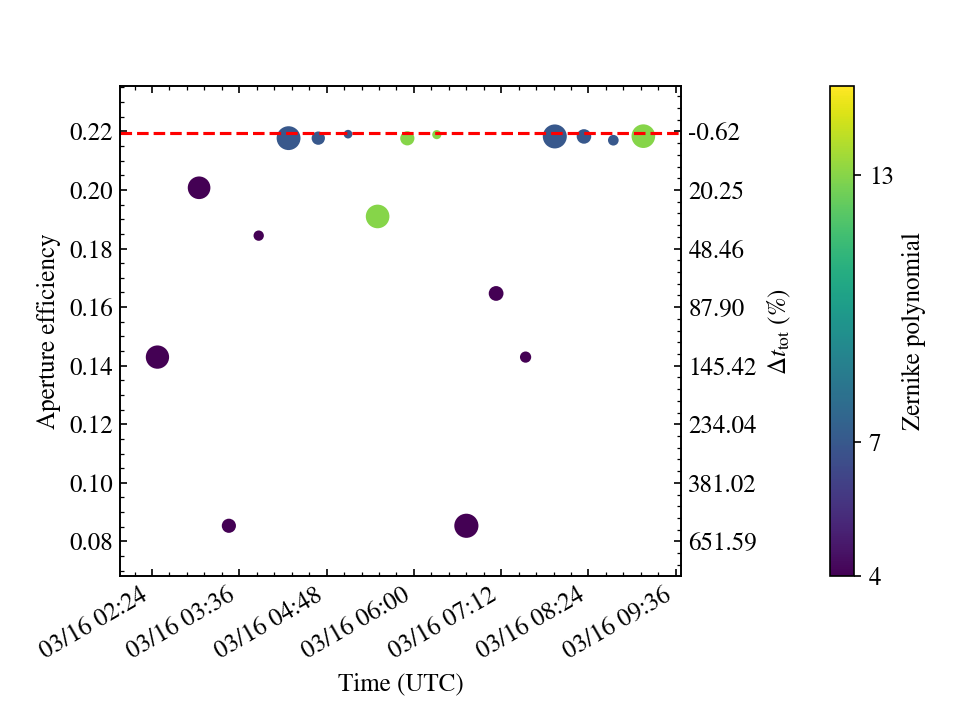

In [87]:
from matplotlib.dates import DateFormatter
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('font', **{'family':'STIXGeneral', 'weight':'normal'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams.update({'font.size': 12})

formatter = DateFormatter('%m/%d %H:%M')

fig = plt.figure(dpi=150, frameon=False)

ax = fig.add_subplot(111)
axr = ax.twinx()

ax.axhline(y=np.max(eta_tot), color='r', linestyle='--')

#nw = (w[1:-5] - np.min(w[1:-5]))/(np.max(w[1:-5]) - np.min(w[1:-5]))
zc = zin
vmax = 15
vmin = 4
cmap = plt.cm.viridis
norm = plt.matplotlib.colors.Normalize(vmin, vmax, clip=True)
colors = norm(zc)
colors = cmap(colors)
mapper = plt.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
# Now set the alpha channel to the one we created above
#colors[..., -1] = 1. - nw

sc = ax.scatter(time.plot_date, eta_res, c=colors, s=abs(zinval)/5., marker='o')

cb = plt.colorbar(sc, fraction=0.046, pad=0.2, ticks=[norm(i) for i in np.unique(zc)])
cb.ax.set_yticklabels(np.unique(zc).astype(np.int))
cb.set_label('Zernike polynomial')

ax.minorticks_on()
ax.tick_params('both', direction='in', which='both', top=True, right=False, left=True, bottom=True)
ax.set_ylabel("Aperture efficiency")

ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Time (UTC)')

l = ax.get_ylim()
l2 = axr.get_ylim()
f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
ticks = f(ax.get_yticks())
axr.yaxis.set_major_locator(plt.matplotlib.ticker.FixedLocator(ticks))

labels = ["{:.2f}".format((np.power(eta_/np.nanmax(eta_tot), -2.) - 1)*100.) for eta_ in ax.get_yticks()]
axr.set_yticklabels(labels)
axr.set_ylabel("$\Delta t_{\mathrm{tot}}$ (%)")
axr.minorticks_on()
axr.tick_params('both', direction='in', which='both', top=False, right=True, left=False, bottom=False)
axr.yaxis.set_minor_locator(plt.matplotlib.ticker.AutoMinorLocator(5))

fig.autofmt_xdate()

#plt.savefig("eta_scan_March2020.pdf", bbox_inches='tight', pad_inches=0.06)

In [83]:
idx = 0
print(zin[idx], zinval[idx], zobs[idx].mean()*1e6, eta_res[idx], np.power(eta_res[idx]/np.max(eta_tot), -2.))

4.0 -518.5107406424904 -2391.2826639890686 0.08533317315403559 6.605773603085296


In [69]:
print(np.max(eta_tot), np.mean(eta_res), np.power(np.mean(eta_res)/np.max(eta_tot), -2.), np.power(np.min(eta_res)/np.max(eta_tot), -2.))
erc = np.hstack((eta_res[:7],eta_res[8:]))
print(np.max(eta_tot), np.mean(erc), np.power(np.mean(erc)/np.max(eta_tot), -2.), np.power(np.min(erc)/np.max(eta_tot), -2.))
mask = (zin != 4)
print(np.max(eta_tot), np.mean(eta_res[mask]), np.power(np.mean(eta_res[mask])/np.max(eta_tot), -2.), np.power(np.min(eta_res[mask])/np.max(eta_tot), -2.))

0.21932075789662847 0.21932075789662847 1.0 1.0
0.21932075789662847 0.21932075789662847 1.0 1.0
0.21932075789662847 0.21932075789662847 1.0 1.0


In [70]:
print(np.max(eta_tot), np.mean(eta_res), np.power(np.mean(eta_res)/np.max(eta_tot), -2.))
erc = np.hstack((eta_res[:8],eta_res[9:]))
print(np.max(eta_tot), np.mean(erc), np.power(np.mean(erc)/np.max(eta_tot), -2.))

0.21932075789662847 0.21932075789662847 1.0
0.21932075789662847 0.21932075789662847 1.0


<IPython.core.display.Javascript object>


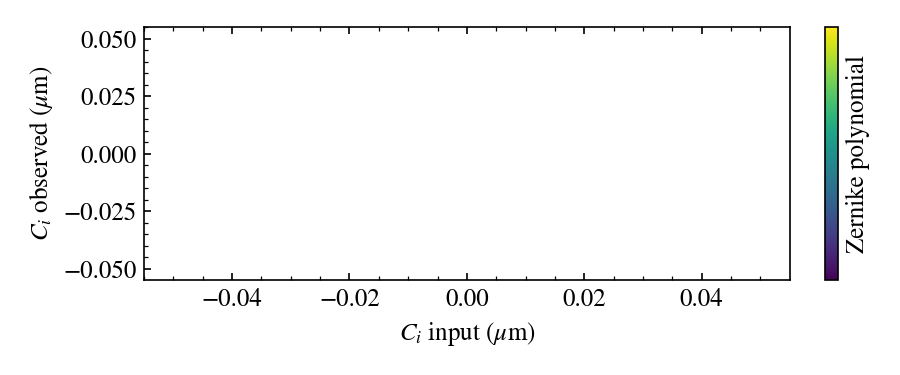

In [71]:
fig = plt.figure(dpi=150, frameon=False, figsize=(6,2.5))

ax = fig.add_subplot(111)

sc = ax.scatter(-1*zinval, -1*zobs*1e6, c=zin, s=abs(zinval)/5., marker='o')

x = np.arange(np.min(-1*zinval),np.max(-1*zinval),10)
y = x
ax.plot(x, y, 'r--')

cb = plt.colorbar(sc, fraction=0.046, pad=0.05, ticks=[4, 7, 13])
cb.set_label('Zernike polynomial')

ax.minorticks_on()
ax.tick_params('both', direction='in', which='both', top=True, right=False, left=True, bottom=True)

ax.set_ylabel("$C_{i}$ observed ($\mu$m)")
ax.set_xlabel("$C_{i}$ input ($\mu$m)")

fig.tight_layout()

In [72]:
zern_files[1]

'/home/gbtdata/TLASSI_200315/LASSI/2020_03_16_03:02:51.zernike.fits'